In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv
/kaggle/input/plantsds/plant-species-names-ner-dataset.csv


**Model 1 : Vanilla Rnn**

In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import numpy as np

data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"  # Adjust the path as needed
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0 

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id[token] for token in tokens]
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [7]:
import torch.nn as nn

class VanillaRNNNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(VanillaRNNNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x) 
        output, _ = self.rnn(embedded)  
        logits = self.fc(output) 
        return logits

In [8]:
vocab_size = len(word_to_id) + 1  
embedding_dim = 64
hidden_dim = 128
num_classes = len(label_to_id)

model = VanillaRNNNER(vocab_size, embedding_dim, hidden_dim, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens) 

        outputs = outputs.view(-1, num_classes) 
        labels = labels.view(-1) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 1.5530
Epoch [2/10], Loss: 0.9838
Epoch [3/10], Loss: 0.7706
Epoch [4/10], Loss: 0.6346
Epoch [5/10], Loss: 0.5338
Epoch [6/10], Loss: 0.4567
Epoch [7/10], Loss: 0.3938
Epoch [8/10], Loss: 0.3453
Epoch [9/10], Loss: 0.3031
Epoch [10/10], Loss: 0.2702


In [10]:
print("Label-to-ID mapping:", label_to_id)
print("Unique valid labels:", set(valid_labels))
print("Unique valid predictions:", set(valid_preds))

Label-to-ID mapping: {'DISPOSITION': 1, 'DESCRIPTEUR': 2, 'COULEUR': 3, 'MESURE': 4, 'POSITION': 5, 'ORGANE': 6, 'FORME': 7, 'DEVELOPPEMENT': 8, 'STRUCTURE': 9, 'SURFACE': 10, 'O': 0}
Unique valid labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Unique valid predictions: {1, 2, 3, 4, 5, 6, 7, 9, 10}


In [11]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for tokens, labels in test_loader:
        tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens) 
        preds = torch.argmax(outputs, dim=-1)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

valid_label_ids = sorted(set(valid_labels) | set(valid_preds))

valid_target_names = [k for k, v in label_to_id.items() if v in valid_label_ids]

print(classification_report(valid_labels, valid_preds, labels=valid_label_ids, target_names=valid_target_names))

               precision    recall  f1-score   support

  DISPOSITION       0.92      0.61      0.74       111
  DESCRIPTEUR       0.78      0.80      0.79       859
      COULEUR       0.93      0.86      0.89       129
       MESURE       0.91      0.83      0.87       418
     POSITION       0.94      0.95      0.95       110
       ORGANE       0.93      0.96      0.94      2757
        FORME       0.86      0.84      0.85       466
DEVELOPPEMENT       0.00      0.00      0.00        15
    STRUCTURE       0.88      0.77      0.82        94
      SURFACE       0.80      0.84      0.82       394

     accuracy                           0.89      5353
    macro avg       0.79      0.75      0.77      5353
 weighted avg       0.89      0.89      0.89      5353



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


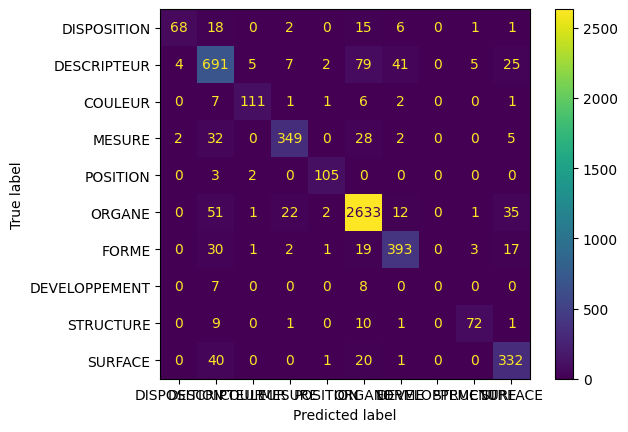

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(valid_labels, valid_preds, display_labels=valid_target_names)
plt.show()


In [13]:
model_save_path = "vanillamodel.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to vanillamodel.pth


**Model 2 : PeepholeLSTM**

In [14]:
data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"  # Adjust the path as needed
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0 

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id[token] for token in tokens]
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [15]:
import torch
import torch.nn as nn

class PeepholeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PeepholeLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wci = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wcf = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wco = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxg = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size, bias=False)
        
    def forward(self, x_t, h_prev, c_prev):
        # Input gate
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + self.Wci(c_prev))
        
        # Forget gate
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + self.Wcf(c_prev))
        
        # Cell candidate
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        
        # Cell state
        c_t = f_t * c_prev + i_t * g_t
        
        # Output gate
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + self.Wco(c_t))
        
        # Hidden state
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t

# LSTM
class LSTMNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = PeepholeLSTMCell(embedding_dim, hidden_size)
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        outputs = []
        for t in range(seq_len):
            x_t = embedded[:, t, :]
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)
            outputs.append(h_t)
        
        outputs = torch.stack(outputs, dim=1) 
        logits = self.fc(outputs) 
        return logits

In [16]:
vocab_size = len(word_to_id) + 1 
embedding_dim = 64
hidden_size = 128
num_classes = len(label_to_id)

model = LSTMNER(vocab_size, embedding_dim, hidden_size, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens) 

        outputs = outputs.view(-1, num_classes) 
        labels = labels.view(-1) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/10], Loss: 1.7740
Epoch [2/10], Loss: 1.2387
Epoch [3/10], Loss: 0.9222
Epoch [4/10], Loss: 0.7209
Epoch [5/10], Loss: 0.5871
Epoch [6/10], Loss: 0.4895
Epoch [7/10], Loss: 0.4114
Epoch [8/10], Loss: 0.3480
Epoch [9/10], Loss: 0.2993
Epoch [10/10], Loss: 0.2607


In [19]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for tokens, labels in test_loader:
        tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        preds = torch.argmax(outputs, dim=-1)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

unique_valid_labels = set(valid_labels)
unique_valid_preds = set(valid_preds)

valid_label_ids = sorted(unique_valid_labels | unique_valid_preds)

valid_target_names = [k for k, v in label_to_id.items() if v in valid_label_ids]

print(classification_report(valid_labels, valid_preds, labels=valid_label_ids, target_names=valid_target_names))

               precision    recall  f1-score   support

  DISPOSITION       0.91      0.64      0.75       111
  DESCRIPTEUR       0.78      0.85      0.81       859
      COULEUR       0.99      0.79      0.88       129
       MESURE       0.89      0.89      0.89       418
     POSITION       0.99      0.94      0.96       110
       ORGANE       0.94      0.95      0.95      2757
        FORME       0.89      0.83      0.86       466
DEVELOPPEMENT       0.00      0.00      0.00        15
    STRUCTURE       0.90      0.65      0.75        94
      SURFACE       0.80      0.89      0.84       394

     accuracy                           0.90      5353
    macro avg       0.81      0.74      0.77      5353
 weighted avg       0.90      0.90      0.89      5353



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
model_save_path = "peehole_lstm_model.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to peehole_lstm_model.pth


**Changing Hyperparameters**

In [24]:
data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"  # Adjust the path as needed
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0 

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id[token] for token in tokens]
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  #Changed
test_loader = DataLoader(test_dataset, batch_size=8)

import torch
import torch.nn as nn

class PeepholeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PeepholeLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wci = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wcf = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wco = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxg = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size, bias=False)
        
    def forward(self, x_t, h_prev, c_prev):
        # Input gate
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + self.Wci(c_prev))
        
        # Forget gate
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + self.Wcf(c_prev))
        
        # Cell candidate
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        
        # Cell state
        c_t = f_t * c_prev + i_t * g_t
        
        # Output gate
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + self.Wco(c_t))
        
        # Hidden state
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t

# LSTM
class LSTMNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = PeepholeLSTMCell(embedding_dim, hidden_size)
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)
        
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        outputs = []
        for t in range(seq_len):
            x_t = embedded[:, t, :]
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)
            outputs.append(h_t)
        
        outputs = torch.stack(outputs, dim=1) 
        logits = self.fc(outputs) 
        return logits

vocab_size = len(word_to_id) + 1 
embedding_dim = 128  #Changed
hidden_size = 256  #Changed
num_classes = len(label_to_id)

model = LSTMNER(vocab_size, embedding_dim, hidden_size, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Changed

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens) 

        outputs = outputs.view(-1, num_classes) 
        labels = labels.view(-1) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for tokens, labels in test_loader:
        tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        preds = torch.argmax(outputs, dim=-1)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

unique_valid_labels = set(valid_labels)
unique_valid_preds = set(valid_preds)

valid_label_ids = sorted(unique_valid_labels | unique_valid_preds)

valid_target_names = [k for k, v in label_to_id.items() if v in valid_label_ids]

print(classification_report(valid_labels, valid_preds, labels=valid_label_ids, target_names=valid_target_names))

Epoch [1/30], Loss: 1.4699
Epoch [2/30], Loss: 0.7491
Epoch [3/30], Loss: 0.5186
Epoch [4/30], Loss: 0.3919
Epoch [5/30], Loss: 0.3149
Epoch [6/30], Loss: 0.2569
Epoch [7/30], Loss: 0.2059
Epoch [8/30], Loss: 0.1669
Epoch [9/30], Loss: 0.1308
Epoch [10/30], Loss: 0.1019
Epoch [11/30], Loss: 0.0740
Epoch [12/30], Loss: 0.0549
Epoch [13/30], Loss: 0.0432
Epoch [14/30], Loss: 0.0277
Epoch [15/30], Loss: 0.0195
Epoch [16/30], Loss: 0.0128
Epoch [17/30], Loss: 0.0098
Epoch [18/30], Loss: 0.0074
Epoch [19/30], Loss: 0.0058
Epoch [20/30], Loss: 0.0049
Epoch [21/30], Loss: 0.0043
Epoch [22/30], Loss: 0.0035
Epoch [23/30], Loss: 0.0033
Epoch [24/30], Loss: 0.0028
Epoch [25/30], Loss: 0.0024
Epoch [26/30], Loss: 0.0021
Epoch [27/30], Loss: 0.0018
Epoch [28/30], Loss: 0.0016
Epoch [29/30], Loss: 0.0015
Epoch [30/30], Loss: 0.0013
               precision    recall  f1-score   support

  DISPOSITION       0.91      0.64      0.75       111
  DESCRIPTEUR       0.78      0.85      0.81       859
   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
model_save_path = "peehole_lstm_model2.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to peehole_lstm_model2.pth


**Lowering learning rates**

In [23]:
data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"  # Adjust the path as needed
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0 

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id[token] for token in tokens]
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  #Changed
test_loader = DataLoader(test_dataset, batch_size=8)

import torch
import torch.nn as nn

class PeepholeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PeepholeLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wci = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wcf = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wco = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxg = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size, bias=False)
        
    def forward(self, x_t, h_prev, c_prev):
        # Input gate
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + self.Wci(c_prev))
        
        # Forget gate
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + self.Wcf(c_prev))
        
        # Cell candidate
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        
        # Cell state
        c_t = f_t * c_prev + i_t * g_t
        
        # Output gate
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + self.Wco(c_t))
        
        # Hidden state
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t

# LSTM
class LSTMNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = PeepholeLSTMCell(embedding_dim, hidden_size)
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)
        
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        outputs = []
        for t in range(seq_len):
            x_t = embedded[:, t, :]
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)
            outputs.append(h_t)
        
        outputs = torch.stack(outputs, dim=1) 
        logits = self.fc(outputs) 
        return logits

vocab_size = len(word_to_id) + 1 
embedding_dim = 128  #Changed
hidden_size = 256  #Changed
num_classes = len(label_to_id)

model = LSTMNER(vocab_size, embedding_dim, hidden_size, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Changed

num_epochs = 10
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens) 

        outputs = outputs.view(-1, num_classes) 
        labels = labels.view(-1) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for tokens, labels in test_loader:
        tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        preds = torch.argmax(outputs, dim=-1)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

unique_valid_labels = set(valid_labels)
unique_valid_preds = set(valid_preds)

valid_label_ids = sorted(unique_valid_labels | unique_valid_preds)

valid_target_names = [k for k, v in label_to_id.items() if v in valid_label_ids]

print(classification_report(valid_labels, valid_preds, labels=valid_label_ids, target_names=valid_target_names))

Epoch [1/10], Loss: 1.4754
Epoch [2/10], Loss: 0.7759
Epoch [3/10], Loss: 0.5332
Epoch [4/10], Loss: 0.4057
Epoch [5/10], Loss: 0.3226
Epoch [6/10], Loss: 0.2631
Epoch [7/10], Loss: 0.2165
Epoch [8/10], Loss: 0.1771
Epoch [9/10], Loss: 0.1423
Epoch [10/10], Loss: 0.1145
               precision    recall  f1-score   support

  DISPOSITION       0.91      0.64      0.75       111
  DESCRIPTEUR       0.78      0.85      0.81       859
      COULEUR       0.99      0.79      0.88       129
       MESURE       0.89      0.89      0.89       418
     POSITION       0.99      0.94      0.96       110
       ORGANE       0.94      0.95      0.95      2757
        FORME       0.89      0.83      0.86       466
DEVELOPPEMENT       0.00      0.00      0.00        15
    STRUCTURE       0.90      0.65      0.75        94
      SURFACE       0.80      0.89      0.84       394

     accuracy                           0.90      5353
    macro avg       0.81      0.74      0.77      5353
 weighted av

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Model 3 : CombinedLSTM**

In [27]:
data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"  # Adjust the path as needed
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0 

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id[token] for token in tokens]
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [28]:
class CombinedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(CombinedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Peephole LSTM Layer
        self.peephole_lstm = PeepholeLSTMCell(hidden_dim, hidden_dim)

        # Working Memory LSTM Layer
        self.wm_lstm = WorkingMemoryLSTMCell(hidden_dim, hidden_dim)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len = x.size()

        embedded = self.embedding(x) 

        lstm_out, _ = self.lstm(embedded) 

        h_t = torch.zeros(batch_size, lstm_out.size(-1)).to(x.device)
        c_t = torch.zeros(batch_size, lstm_out.size(-1)).to(x.device)
        peephole_out = []
        for t in range(seq_len):
            h_t, c_t = self.peephole_lstm(lstm_out[:, t, :], h_t, c_t)
            peephole_out.append(h_t)
        peephole_out = torch.stack(peephole_out, dim=1)

        h_t = torch.zeros(batch_size, peephole_out.size(-1)).to(x.device)
        c_t = torch.zeros(batch_size, peephole_out.size(-1)).to(x.device)
        wm_out = []
        for t in range(seq_len):
            h_t, c_t = self.wm_lstm(peephole_out[:, t, :], h_t, c_t)
            wm_out.append(h_t)
        wm_out = torch.stack(wm_out, dim=1) 

        logits = self.fc(wm_out)
        return logits


class PeepholeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PeepholeLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wci = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wcf = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wco = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.Wxg = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x_t, h_prev, c_prev):
        # Input gate
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + self.Wci(c_prev))
        
        # Forget gate
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + self.Wcf(c_prev))
        
        # Cell candidate
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        
        # Cell state
        c_t = f_t * c_prev + i_t * g_t
        
        # Output gate
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + self.Wco(c_t))
        
        # Hidden state
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t


class WorkingMemoryLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WorkingMemoryLSTMCell, self).__init__()
        self.hidden_size = hidden_size

        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wci = nn.Linear(hidden_size, hidden_size, bias=False)

        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wcf = nn.Linear(hidden_size, hidden_size, bias=False)

        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wco = nn.Linear(hidden_size, hidden_size, bias=False)

        self.Wxg = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x_t, h_prev, c_prev):
        # Input gate
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + torch.tanh(self.Wci(c_prev)))

        # Forget gate
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + torch.tanh(self.Wcf(c_prev)))

        # Cell candidate
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))

        # Cell state
        c_t = f_t * c_prev + i_t * g_t

        # Output gate
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + torch.tanh(self.Wco(c_t)))

        # Hidden state
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t


In [29]:
vocab_size = len(word_to_id) + 1
embedding_dim = 128
hidden_dim = 256
num_classes = len(label_to_id)

model = CombinedLSTMModel(vocab_size, embedding_dim, hidden_dim, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(tokens)
        outputs = outputs.view(-1, num_classes)
        labels = labels.view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/20], Loss: 1.7216
Epoch [2/20], Loss: 1.4980
Epoch [3/20], Loss: 1.0671
Epoch [4/20], Loss: 0.8140
Epoch [5/20], Loss: 0.5892
Epoch [6/20], Loss: 0.4303
Epoch [7/20], Loss: 0.3268
Epoch [8/20], Loss: 0.2386
Epoch [9/20], Loss: 0.1785
Epoch [10/20], Loss: 0.1272
Epoch [11/20], Loss: 0.0967
Epoch [12/20], Loss: 0.0757
Epoch [13/20], Loss: 0.0542
Epoch [14/20], Loss: 0.0492
Epoch [15/20], Loss: 0.0345
Epoch [16/20], Loss: 0.0238
Epoch [17/20], Loss: 0.0178
Epoch [18/20], Loss: 0.0159
Epoch [19/20], Loss: 0.0104
Epoch [20/20], Loss: 0.0076


In [31]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for tokens, labels in test_loader:
        tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        preds = torch.argmax(outputs, dim=-1)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

active_label_ids = sorted(set(valid_labels) | set(valid_preds))

active_target_names = [label for label, id_ in label_to_id.items() if id_ in active_label_ids]

print(classification_report(valid_labels, valid_preds, labels=active_label_ids, target_names=active_target_names))

               precision    recall  f1-score   support

  DISPOSITION       0.80      0.72      0.76       111
  DESCRIPTEUR       0.79      0.87      0.82       859
      COULEUR       0.94      0.90      0.92       129
       MESURE       0.93      0.83      0.88       418
     POSITION       0.98      0.97      0.98       110
       ORGANE       0.95      0.95      0.95      2757
        FORME       0.95      0.89      0.92       466
DEVELOPPEMENT       0.56      0.33      0.42        15
    STRUCTURE       0.77      0.84      0.81        94
      SURFACE       0.87      0.87      0.87       394

     accuracy                           0.91      5353
    macro avg       0.85      0.82      0.83      5353
 weighted avg       0.91      0.91      0.91      5353



In [32]:
model_save_path = "combined_lstm_model.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to combined_lstm_model.pth


**Changing Hyperparameters**

In [33]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from sklearn.utils.class_weight import compute_class_weight

# Load and preprocess data
data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)}
label_to_id['O'] = 0  # Add "O" as non-entity label

# Encode annotations
def encode_annotations(text, annotations, max_length=256):
    tokens = word_tokenize(text)
    token_ids = [word_to_id[token] for token in tokens]
    labels = [0] * len(tokens)

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))
    return token_ids, labels

max_length = 256
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

# Dataset and DataLoader
class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Combined LSTM Model
class CombinedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(CombinedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.peephole_lstm = PeepholeLSTMCell(hidden_dim, hidden_dim)
        self.wm_lstm = WorkingMemoryLSTMCell(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len = x.size()

        embedded = self.dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)

        h_t = torch.zeros(batch_size, lstm_out.size(-1)).to(x.device)
        c_t = torch.zeros(batch_size, lstm_out.size(-1)).to(x.device)
        peephole_out = []
        for t in range(seq_len):
            h_t, c_t = self.peephole_lstm(lstm_out[:, t, :], h_t, c_t)
            peephole_out.append(h_t)
        peephole_out = torch.stack(peephole_out, dim=1)

        h_t = torch.zeros(batch_size, peephole_out.size(-1)).to(x.device)
        c_t = torch.zeros(batch_size, peephole_out.size(-1)).to(x.device)
        wm_out = []
        for t in range(seq_len):
            h_t, c_t = self.wm_lstm(peephole_out[:, t, :], h_t, c_t)
            wm_out.append(h_t)
        wm_out = torch.stack(wm_out, dim=1)

        logits = self.fc(wm_out)
        return logits

# Peephole LSTM Cell
class PeepholeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PeepholeLSTMCell, self).__init__()
        self.Wxi, self.Whi, self.Wci = nn.Linear(input_size, hidden_size), nn.Linear(hidden_size, hidden_size, bias=False), nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wxf, self.Whf, self.Wcf = nn.Linear(input_size, hidden_size), nn.Linear(hidden_size, hidden_size, bias=False), nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wxo, self.Who, self.Wco = nn.Linear(input_size, hidden_size), nn.Linear(hidden_size, hidden_size, bias=False), nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wxg, self.Whg = nn.Linear(input_size, hidden_size), nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x_t, h_prev, c_prev):
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + self.Wci(c_prev))
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + self.Wcf(c_prev))
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        c_t = f_t * c_prev + i_t * g_t
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + self.Wco(c_t))
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t

# Working Memory LSTM Cell
class WorkingMemoryLSTMCell(PeepholeLSTMCell):
    def forward(self, x_t, h_prev, c_prev):
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + torch.tanh(self.Wci(c_prev)))
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + torch.tanh(self.Wcf(c_prev)))
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        c_t = f_t * c_prev + i_t * g_t
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + torch.tanh(self.Wco(c_t)))
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t

# Model, Loss, and Optimizer
vocab_size = len(word_to_id) + 1
embedding_dim = 256
hidden_dim = 512
num_classes = len(label_to_id)

model = CombinedLSTMModel(vocab_size, embedding_dim, hidden_dim, num_classes)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

class_weights = compute_class_weight('balanced', classes=list(range(len(label_to_id))), y=[l for _, labels in train_data for l in labels])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(model.fc.weight.device)

criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for tokens, labels in train_loader:
        tokens, labels = tokens.to(model.fc.weight.device), labels.to(model.fc.weight.device)
        optimizer.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs.view(-1, num_classes), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens, labels = tokens.to(model.fc.weight.device), labels.to(model.fc.weight.device)
        preds = torch.argmax(model(tokens), dim=-1)
        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

valid_preds = [p for p, l in zip(all_preds, all_labels) if l != 0]
valid_labels = [l for l in all_labels if l != 0]
print(classification_report(valid_labels, valid_preds, target_names=[k for k, v in label_to_id.items() if v in set(valid_labels)]))


Epoch [1/20], Loss: 2.0732
Epoch [2/20], Loss: 1.1835
Epoch [3/20], Loss: 0.6612
Epoch [4/20], Loss: 0.4171
Epoch [5/20], Loss: 0.3077
Epoch [6/20], Loss: 0.2490
Epoch [7/20], Loss: 0.2042
Epoch [8/20], Loss: 0.1644
Epoch [9/20], Loss: 0.1417
Epoch [10/20], Loss: 0.1331
Epoch [11/20], Loss: 0.1174
Epoch [12/20], Loss: 0.1064
Epoch [13/20], Loss: 0.0908
Epoch [14/20], Loss: 0.0752
Epoch [15/20], Loss: 0.0687
Epoch [16/20], Loss: 0.0605
Epoch [17/20], Loss: 0.0626
Epoch [18/20], Loss: 0.0535
Epoch [19/20], Loss: 0.0424
Epoch [20/20], Loss: 0.0412
               precision    recall  f1-score   support

  DISPOSITION       0.83      0.86      0.85       147
  DESCRIPTEUR       0.86      0.91      0.88      1346
      COULEUR       0.93      0.93      0.93       191
       MESURE       0.93      0.91      0.92       674
     POSITION       1.00      0.99      1.00       169
       ORGANE       0.97      0.95      0.96      4544
        FORME       0.92      0.90      0.91       699
DEVELOPP

In [34]:
model_save_path = "combined_lstm_model2.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to combined_lstm_model2.pth


**Comparing the three models**

In [60]:
import torch.nn as nn

class VanillaRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(VanillaRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x) 
        output, _ = self.rnn(embedded) 
        logits = self.fc(output) 
        return logits

class PeepholeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()  # Corrected super() call
        self.hidden_size = hidden_size
        
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wci = nn.Linear(hidden_size, hidden_size, bias=False)

        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wcf = nn.Linear(hidden_size, hidden_size, bias=False)

        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wco = nn.Linear(hidden_size, hidden_size, bias=False)

        self.Wxg = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x_t, h_prev, c_prev):
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + self.Wci(c_prev))
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + self.Wcf(c_prev))
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        c_t = f_t * c_prev + i_t * g_t
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + self.Wco(c_t))
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t
class WorkingMemoryLSTMCell(PeepholeLSTMCell):
    def __init__(self, input_size, hidden_size):
        super().__init__(input_size, hidden_size)  # Ensure the correct initialization

    def forward(self, x_t, h_prev, c_prev):
        i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_prev) + torch.tanh(self.Wci(c_prev)))
        f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_prev) + torch.tanh(self.Wcf(c_prev)))
        g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_prev))
        c_t = f_t * c_prev + i_t * g_t
        o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_prev) + torch.tanh(self.Wco(c_t)))
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t

class CombinedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(CombinedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.peephole_lstm = PeepholeLSTMCell(hidden_dim, hidden_dim)
        self.wm_lstm = WorkingMemoryLSTMCell(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len = x.size()

        embedded = self.dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)  

        h_t = torch.zeros(batch_size, lstm_out.size(-1)).to(x.device)
        c_t = torch.zeros(batch_size, lstm_out.size(-1)).to(x.device)
        peephole_out = []
        for t in range(seq_len):
            h_t, c_t = self.peephole_lstm(lstm_out[:, t, :], h_t, c_t)
            peephole_out.append(h_t)
        peephole_out = torch.stack(peephole_out, dim=1)  
        
        h_t = torch.zeros(batch_size, peephole_out.size(-1)).to(x.device)
        c_t = torch.zeros(batch_size, peephole_out.size(-1)).to(x.device)
        wm_out = []
        for t in range(seq_len):
            h_t, c_t = self.wm_lstm(peephole_out[:, t, :], h_t, c_t)
            wm_out.append(h_t)
        wm_out = torch.stack(wm_out, dim=1) 
        
        logits = self.fc(wm_out) 
        return logits


In [61]:
#Loading models
# Vanilla Model
vanilla_model = VanillaRNNModel(vocab_size, embedding_dim=64, hidden_dim=128, num_classes=num_classes)
vanilla_model.load_state_dict(torch.load("/kaggle/working/vanillamodel.pth"))
vanilla_model.to(device)


# Peephole LSTM Model
peehole_lstm_model = PeepholeLSTMModel(vocab_size, embedding_dim=128, hidden_dim=256, num_classes=num_classes)
peehole_lstm_model.load_state_dict(torch.load("/kaggle/working/peehole_lstm_model2.pth"))
peehole_lstm_model.to(device)

# Combined LSTM Model
combined_lstm_model = CombinedLSTMModel(vocab_size, embedding_dim, hidden_dim, num_classes)
combined_lstm_model.load_state_dict(torch.load("/kaggle/working/combined_lstm_model2.pth"))
combined_lstm_model.to(device)


/tmp/ipykernel_23/1631772129.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vanilla_model.load_state_dict(torch.load("/kaggle/working/vanillamodel.pth"))
/tmp/ipykernel

CombinedLSTMModel(
  (embedding): Embedding(9159, 256)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(256, 512, batch_first=True)
  (peephole_lstm): PeepholeLSTMCell(
    (Wxi): Linear(in_features=512, out_features=512, bias=True)
    (Whi): Linear(in_features=512, out_features=512, bias=False)
    (Wci): Linear(in_features=512, out_features=512, bias=False)
    (Wxf): Linear(in_features=512, out_features=512, bias=True)
    (Whf): Linear(in_features=512, out_features=512, bias=False)
    (Wcf): Linear(in_features=512, out_features=512, bias=False)
    (Wxo): Linear(in_features=512, out_features=512, bias=True)
    (Who): Linear(in_features=512, out_features=512, bias=False)
    (Wco): Linear(in_features=512, out_features=512, bias=False)
    (Wxg): Linear(in_features=512, out_features=512, bias=True)
    (Whg): Linear(in_features=512, out_features=512, bias=False)
  )
  (wm_lstm): WorkingMemoryLSTMCell(
    (Wxi): Linear(in_features=512, out_features=512, bias=True)
    (Wh

In [62]:
#Evaluation function

from sklearn.metrics import classification_report

def evaluate_model(model, test_loader, label_to_id):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for tokens, labels in test_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            outputs = model(tokens)
            preds = torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    valid_preds = [p for p, l in zip(all_preds, all_labels) if l != 0]
    valid_labels = [l for l in all_labels if l != 0]

    target_names = [k for k, v in label_to_id.items() if v in set(valid_labels)]
    report = classification_report(valid_labels, valid_preds, target_names=target_names, output_dict=True)
    return report


In [64]:
#Evaluating models
def evaluate_model(model, test_loader, label_to_id):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for tokens, labels in test_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            outputs = model(tokens)
            preds = torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    valid_preds = [p for p, l in zip(all_preds, all_labels) if l != 0]
    valid_labels = [l for l in all_labels if l != 0]

    target_names = [k for k, v in label_to_id.items() if v in set(valid_labels)]
    report = classification_report(
        valid_labels, valid_preds, target_names=target_names, zero_division=0, output_dict=True
    )
    return report

# Vanilla Model
vanilla_report = evaluate_model(vanilla_model, test_loader, label_to_id)

# Model 2
peehole_lstm_report = evaluate_model(peehole_lstm_model, test_loader, label_to_id)

# Model 3
combined_lstm_report = evaluate_model(combined_lstm_model, test_loader, label_to_id)

In [65]:
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.to(device)
        outputs = model(tokens)  # Raw logits
        probs = torch.softmax(outputs, dim=-1)  # Probabilities
        print(f"Predictions: {torch.argmax(probs, dim=-1)}")
        print(f"Probabilities for each class: {probs}")

Predictions: tensor([[ 8,  2, 10,  ...,  2,  2,  2],
        [ 6,  6,  6,  ...,  4,  4,  3],
        [ 6,  2,  2,  ...,  2,  2,  2],
        ...,
        [ 6,  2,  2,  ...,  2,  2,  2],
        [ 6,  7,  4,  ...,  2,  2,  2],
        [ 6,  2,  2,  ...,  2,  2,  2]], device='cuda:0')
Probabilities for each class: tensor([[[6.3947e-02, 6.5189e-02, 9.1994e-02,  ..., 3.1206e-01,
          4.8068e-02, 4.2191e-02],
         [1.8714e-02, 2.0220e-02, 3.0060e-01,  ..., 9.3082e-02,
          3.2805e-02, 1.1329e-01],
         [4.5717e-04, 4.9679e-03, 1.5446e-01,  ..., 3.0874e-03,
          4.8291e-02, 6.8212e-01],
         ...,
         [4.8207e-05, 2.5538e-03, 5.1431e-01,  ..., 3.6218e-03,
          2.6962e-01, 3.3470e-03],
         [4.8176e-05, 2.5525e-03, 5.1440e-01,  ..., 3.6204e-03,
          2.6958e-01, 3.3465e-03],
         [4.8147e-05, 2.5512e-03, 5.1448e-01,  ..., 3.6190e-03,
          2.6954e-01, 3.3461e-03]],

        [[5.2064e-06, 1.2492e-04, 1.1510e-04,  ..., 4.9410e-05,
          7.

**Comparison Table**

In [66]:
import pandas as pd

def create_comparison_table(vanilla_report, peehole_lstm_report, combined_lstm_report):
    classes = list(vanilla_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

    metrics = ['precision', 'recall', 'f1-score']
    data = []

    for cls in classes:
        row = {
            'Class': cls,
            'Vanilla_Precision': vanilla_report[cls]['precision'],
            'Vanilla_Recall': vanilla_report[cls]['recall'],
            'Vanilla_F1': vanilla_report[cls]['f1-score'],
            'Peephole_Precision': peehole_lstm_report[cls]['precision'],
            'Peephole_Recall': peehole_lstm_report[cls]['recall'],
            'Peephole_F1': peehole_lstm_report[cls]['f1-score'],
            'Combined_Precision': combined_lstm_report[cls]['precision'],
            'Combined_Recall': combined_lstm_report[cls]['recall'],
            'Combined_F1': combined_lstm_report[cls]['f1-score']
        }
        data.append(row)

    df = pd.DataFrame(data)
    return df


In [68]:
import pandas as pd

print(comparison_table)


           Class  Vanilla_Precision  Vanilla_Recall  Vanilla_F1  \
0    DISPOSITION           0.835052        0.551020    0.663934   
1    DESCRIPTEUR           0.741318        0.777117    0.758796   
2        COULEUR           0.915254        0.848168    0.880435   
3         MESURE           0.897351        0.804154    0.848200   
4       POSITION           0.935897        0.863905    0.898462   
5         ORGANE           0.932127        0.952025    0.941971   
6          FORME           0.817518        0.801144    0.809249   
7  DEVELOPPEMENT           0.000000        0.000000    0.000000   
8      STRUCTURE           0.762963        0.720280    0.741007   
9        SURFACE           0.808605        0.837174    0.822642   

   Peephole_Precision  Peephole_Recall  Peephole_F1  Combined_Precision  \
0            0.838983         0.673469     0.747170            0.834437   
1            0.781048         0.808321     0.794451            0.860465   
2            0.954023         0.86911

In [69]:
comparison_table.to_csv("model_comparison_table.csv", index=False)
print("Comparison table saved as 'model_comparison_table.csv'.")

Comparison table saved as 'model_comparison_table.csv'.


**Plotting F1-Scores**

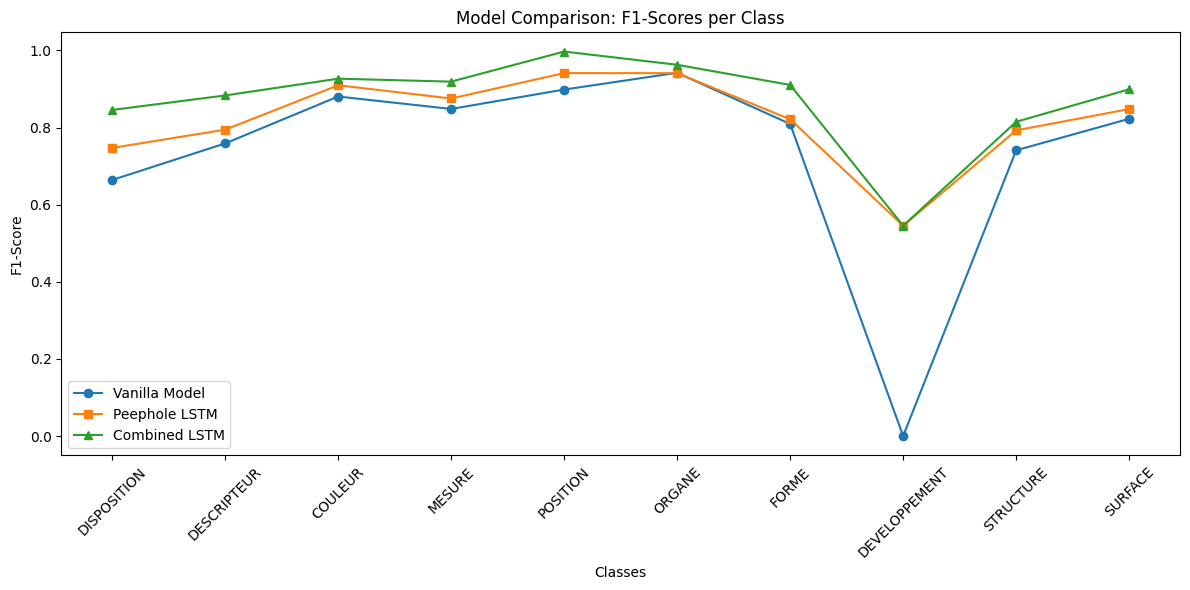

In [70]:
import matplotlib.pyplot as plt

def plot_f1_scores(comparison_table):
    classes = comparison_table['Class']
    vanilla_f1 = comparison_table['Vanilla_F1']
    peehole_f1 = comparison_table['Peephole_F1']
    combined_f1 = comparison_table['Combined_F1']

    plt.figure(figsize=(12, 6))
    plt.plot(classes, vanilla_f1, label='Vanilla Model', marker='o')
    plt.plot(classes, peehole_f1, label='Peephole LSTM', marker='s')
    plt.plot(classes, combined_f1, label='Combined LSTM', marker='^')
    plt.xticks(rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('F1-Score')
    plt.title('Model Comparison: F1-Scores per Class')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_f1_scores(comparison_table)

**Heatmap for Metric Comparison**

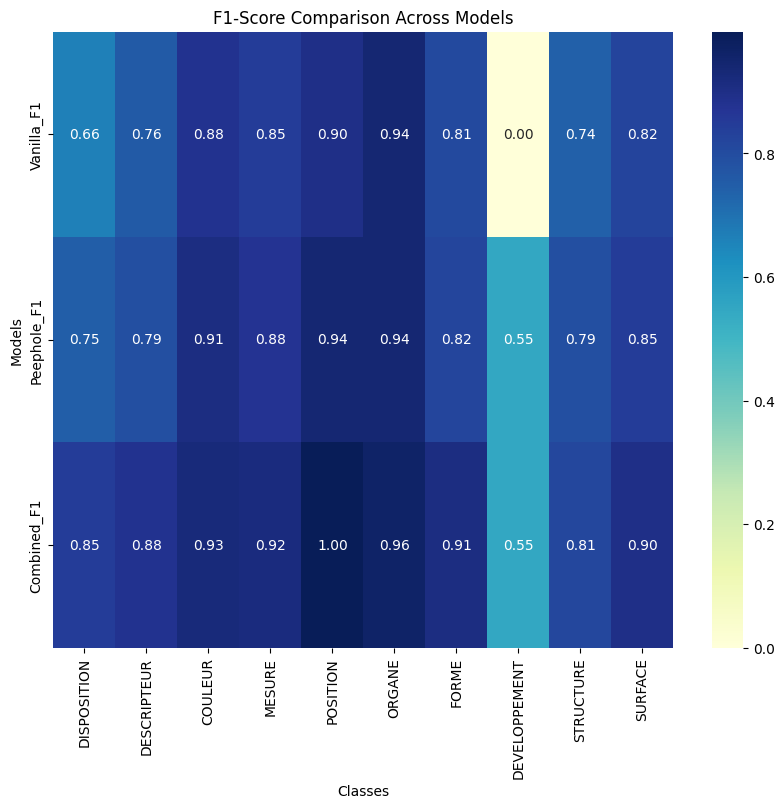

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(comparison_table):
    metrics = ['Vanilla_F1', 'Peephole_F1', 'Combined_F1']
    heatmap_data = comparison_table[['Class'] + metrics].set_index('Class').T

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title('F1-Score Comparison Across Models')
    plt.ylabel('Models')
    plt.xlabel('Classes')
    plt.show()

plot_heatmap(comparison_table)

**Bar Chart for Metrics per Class**

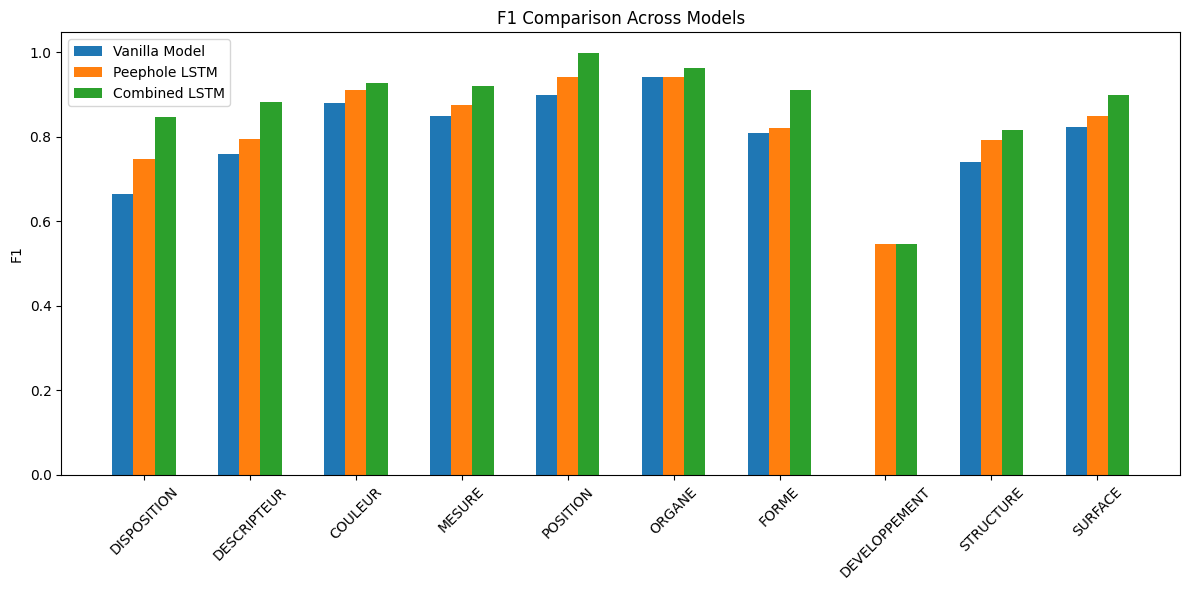

In [73]:
def plot_grouped_bar_chart(comparison_table, metric):
    classes = comparison_table['Class']
    vanilla_metric = comparison_table[f'Vanilla_{metric}']
    peehole_metric = comparison_table[f'Peephole_{metric}']
    combined_metric = comparison_table[f'Combined_{metric}']

    x = range(len(classes))
    bar_width = 0.2

    plt.figure(figsize=(12, 6))
    plt.bar([p - bar_width for p in x], vanilla_metric, width=bar_width, label='Vanilla Model')
    plt.bar(x, peehole_metric, width=bar_width, label='Peephole LSTM')
    plt.bar([p + bar_width for p in x], combined_metric, width=bar_width, label='Combined LSTM')

    plt.xticks(x, classes, rotation=45)
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison Across Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_grouped_bar_chart(comparison_table, 'F1')